In [441]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json

from sklearn.model_selection import (
    train_test_split, cross_val_score, ShuffleSplit, GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

In [442]:
df = pd.read_csv('/home/akeemlag/Downloads/car_price_prediction.csv')

In [443]:
"""EXPLORATORY DATA ANALYSIS"""

'EXPLORATORY DATA ANALYSIS'

In [444]:
df.head(20)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
5,45802912,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2,160931 km,4.0,Automatic,Front,04-May,Left wheel,White,4
6,45656768,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4.0,Automatic,Front,04-May,Left wheel,White,12
7,45816158,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118 km,4.0,Automatic,Front,04-May,Left wheel,Grey,12
8,45641395,1098,394,TOYOTA,Camry,2014,Sedan,Yes,Hybrid,2.5,398069 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
9,45756839,26657,-,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12


In [445]:
print(df.shape)
print(df.info())

(19237, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-

In [446]:
df.nunique()

ID                  18924
Price                2315
Levy                  559
Manufacturer           65
Model                1590
Prod. year             54
Category               11
Leather interior        2
Fuel type               7
Engine volume         107
Mileage              7687
Cylinders              13
Gear box type           4
Drive wheels            3
Doors                   3
Wheel                   2
Color                  16
Airbags                17
dtype: int64

""" There roughly 6000 rows with this kind of data that are not int and not null
If we remove such humongous dataset, it will impact our ds training
Proposition is to conver the remaining value to an int, calculate the mean per year and replace the 
the - with the mean
"""

In [447]:
def isInt(x):
    try:
        int(x)
    except:
        return None
    return int(x)

In [448]:
df.Mileage = df.Mileage.apply(lambda x: x.split(' ')[0])

In [449]:
# Convert Levy to int
cols_to_convert = ['Levy', 'Mileage', 'Engine volume']
for col in cols_to_convert:
    print('current col: ', col)
    df[col] = df[col].apply(isInt)
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())
    df[col] = df[col].astype(int)


current col:  Levy


current col:  Mileage
current col:  Engine volume


In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  int64  
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  int64  
 10  Mileage           19237 non-null  int64  
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [451]:
df.describe()

,ID,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,906.584603,2010.912824,2.060248,1.532236e+06,4.582991,6.582627
std,9.365914e+05,1.905813e+05,385.733647,5.668673,0.372783,4.840387e+07,1.199933,4.320168
min,2.074688e+07,1.000000e+00,87.000000,1939.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,730.000000,2009.000000,2.000000,7.013900e+04,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,906.000000,2012.000000,2.000000,1.260000e+05,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,917.000000,2015.000000,2.000000,1.888880e+05,4.000000,12.000000
max,4.581665e+07,2.630750e+07,11714.000000,2020.000000,20.000000,2.147484e+09,16.000000,16.000000


In [452]:
# Check if any cols contain values that are non int in the numerical cols
numerical_cols = df.select_dtypes(include=['int']).columns
print('numerical_cols: ', numerical_cols)
categorical_cols = df.select_dtypes(include=['object']).columns
print('categorical_cols: ',categorical_cols)

numerical_cols:  Index(['ID', 'Price', 'Levy', 'Prod. year', 'Engine volume', 'Mileage',
       'Airbags'],
      dtype='object')
categorical_cols:  Index(['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type',
       'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color'],
      dtype='object')


Let's create a corr heatmap to see features that are closely related 
Features with a 0.85 corr will dropped in place of that which does not 
have an outlier

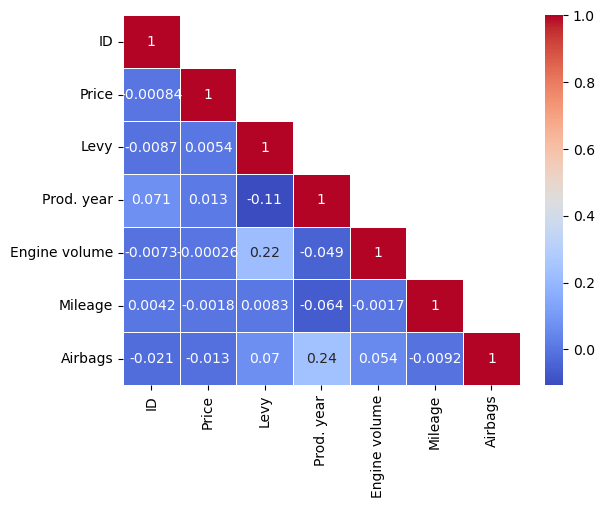

In [453]:
# Corr between numerical cols
corr = df[numerical_cols].corr()
# Remove repetition

mask = ~np.tri(corr.shape[0], k=0, dtype=bool)

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5);

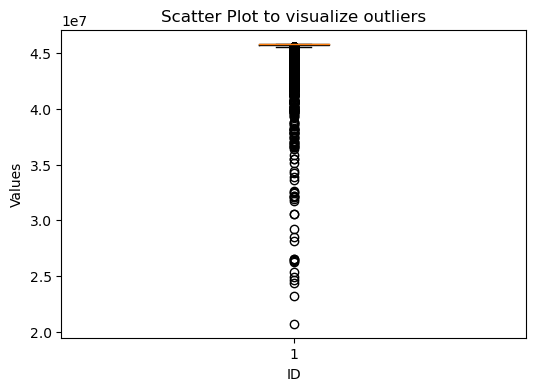

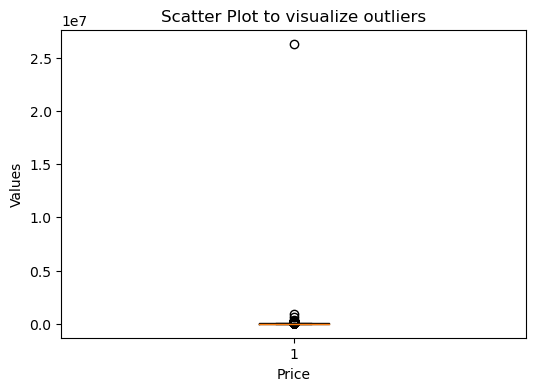

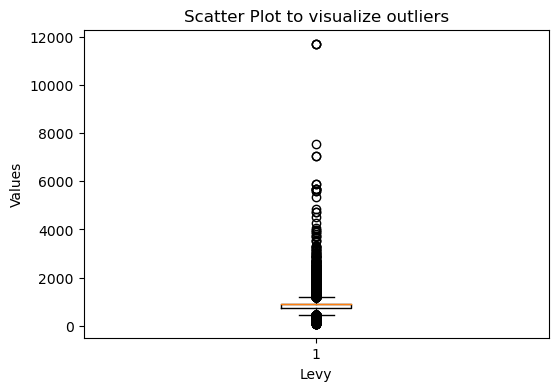

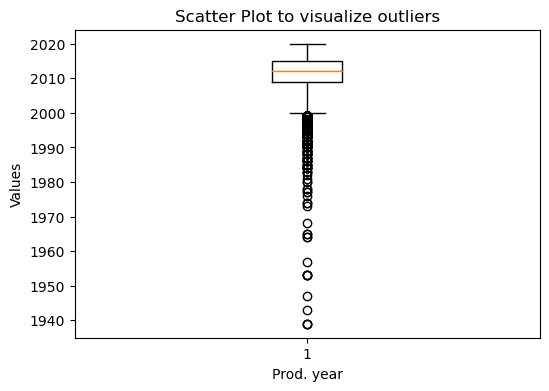

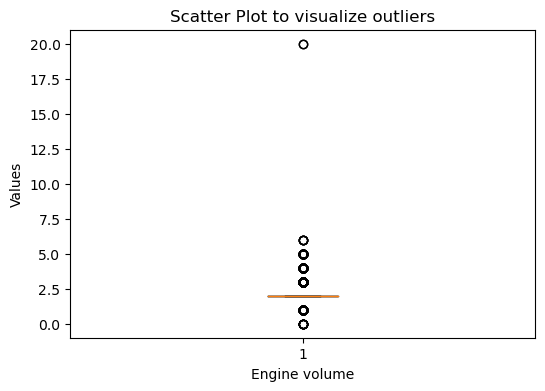

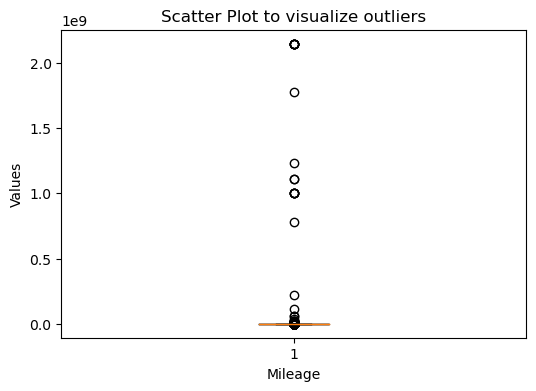

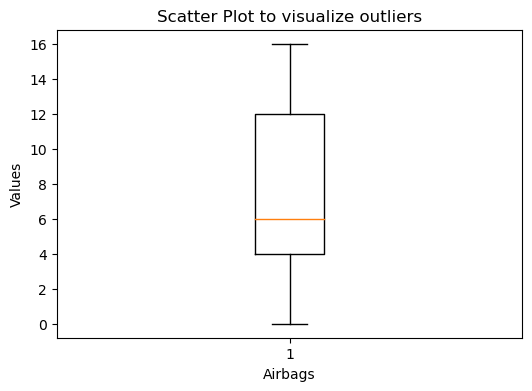

In [454]:
#Create a boc plot to visualize outliers in the numerical cols
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    plt.boxplot(df[col])
    plt.title('Scatter Plot to visualize outliers')
    plt.xlabel(col)
    plt.ylabel('Values')


In [455]:
# Use quantile to remove outliers in our pricing
def get_and_remove_outliers(col, df):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    min_threshold, max_threshold = df[col].quantile([0.10, 0.90])
    
    print(f'upper_limit: ', {max_threshold})
    print(f'lower_limit: ', {min_threshold})
    no_outliers = df[(df[col] < max_threshold) & (df[col] > min_threshold)]

    # To reassign the outliers to the upper_limit
    return no_outliers
    # return df

In [456]:
df = get_and_remove_outliers(df=df, col='Levy')

upper_limit:  {1273.0}
lower_limit:  {583.0}


In [457]:
df = get_and_remove_outliers(df=df, col='Price')

upper_limit:  {39107.80000000008}
lower_limit:  {706.0}


In [458]:
df = get_and_remove_outliers(df=df, col='Mileage')

upper_limit:  {270000.0}
lower_limit:  {27999.2}


In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9770 entries, 1 to 19234
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                9770 non-null   int64  
 1   Price             9770 non-null   int64  
 2   Levy              9770 non-null   int64  
 3   Manufacturer      9770 non-null   object 
 4   Model             9770 non-null   object 
 5   Prod. year        9770 non-null   int64  
 6   Category          9770 non-null   object 
 7   Leather interior  9770 non-null   object 
 8   Fuel type         9770 non-null   object 
 9   Engine volume     9770 non-null   int64  
 10  Mileage           9770 non-null   int64  
 11  Cylinders         9770 non-null   float64
 12  Gear box type     9770 non-null   object 
 13  Drive wheels      9770 non-null   object 
 14  Doors             9770 non-null   object 
 15  Wheel             9770 non-null   object 
 16  Color             9770 non-null   object 
 17 

<AxesSubplot: >

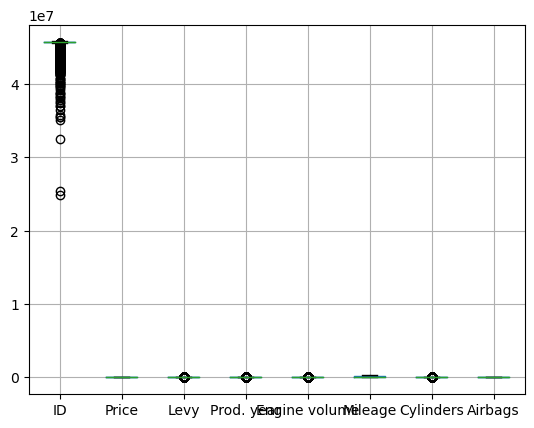

In [460]:
df.boxplot()

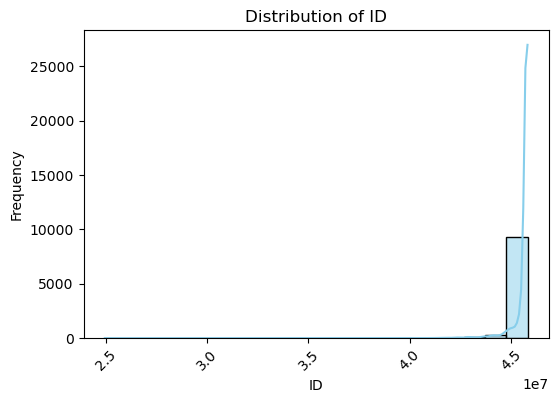

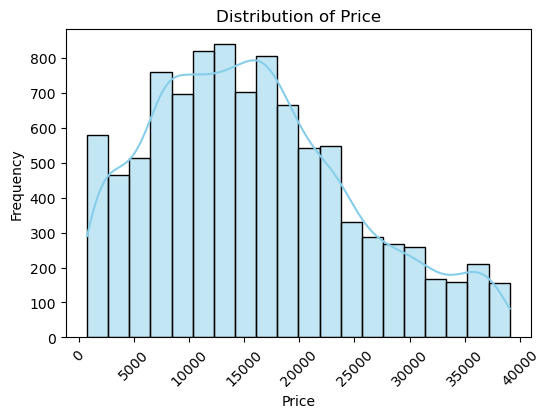

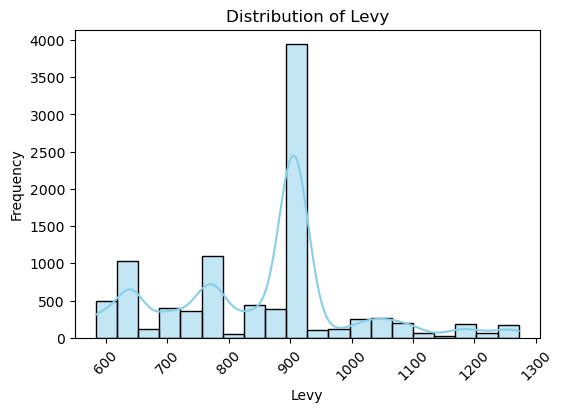

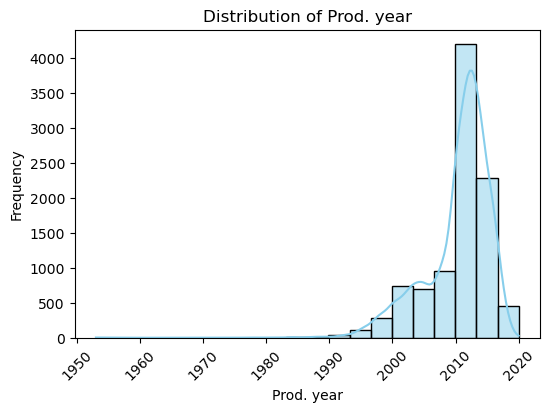

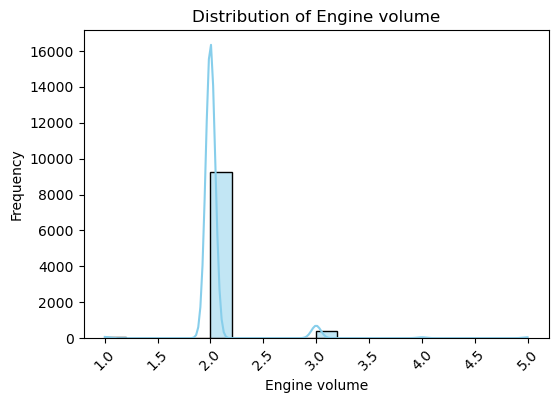

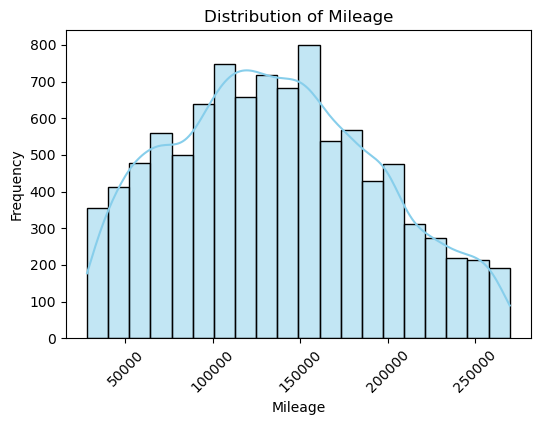

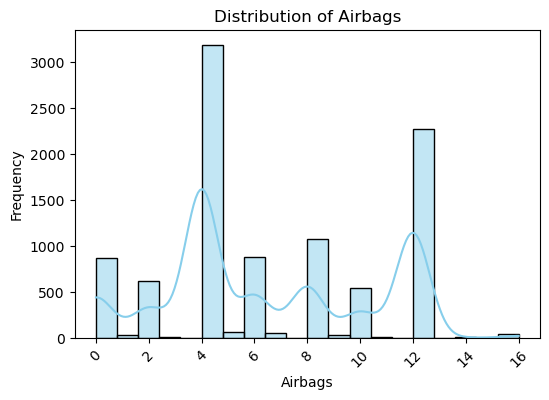

In [461]:
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=20, color='skyblue', kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45);

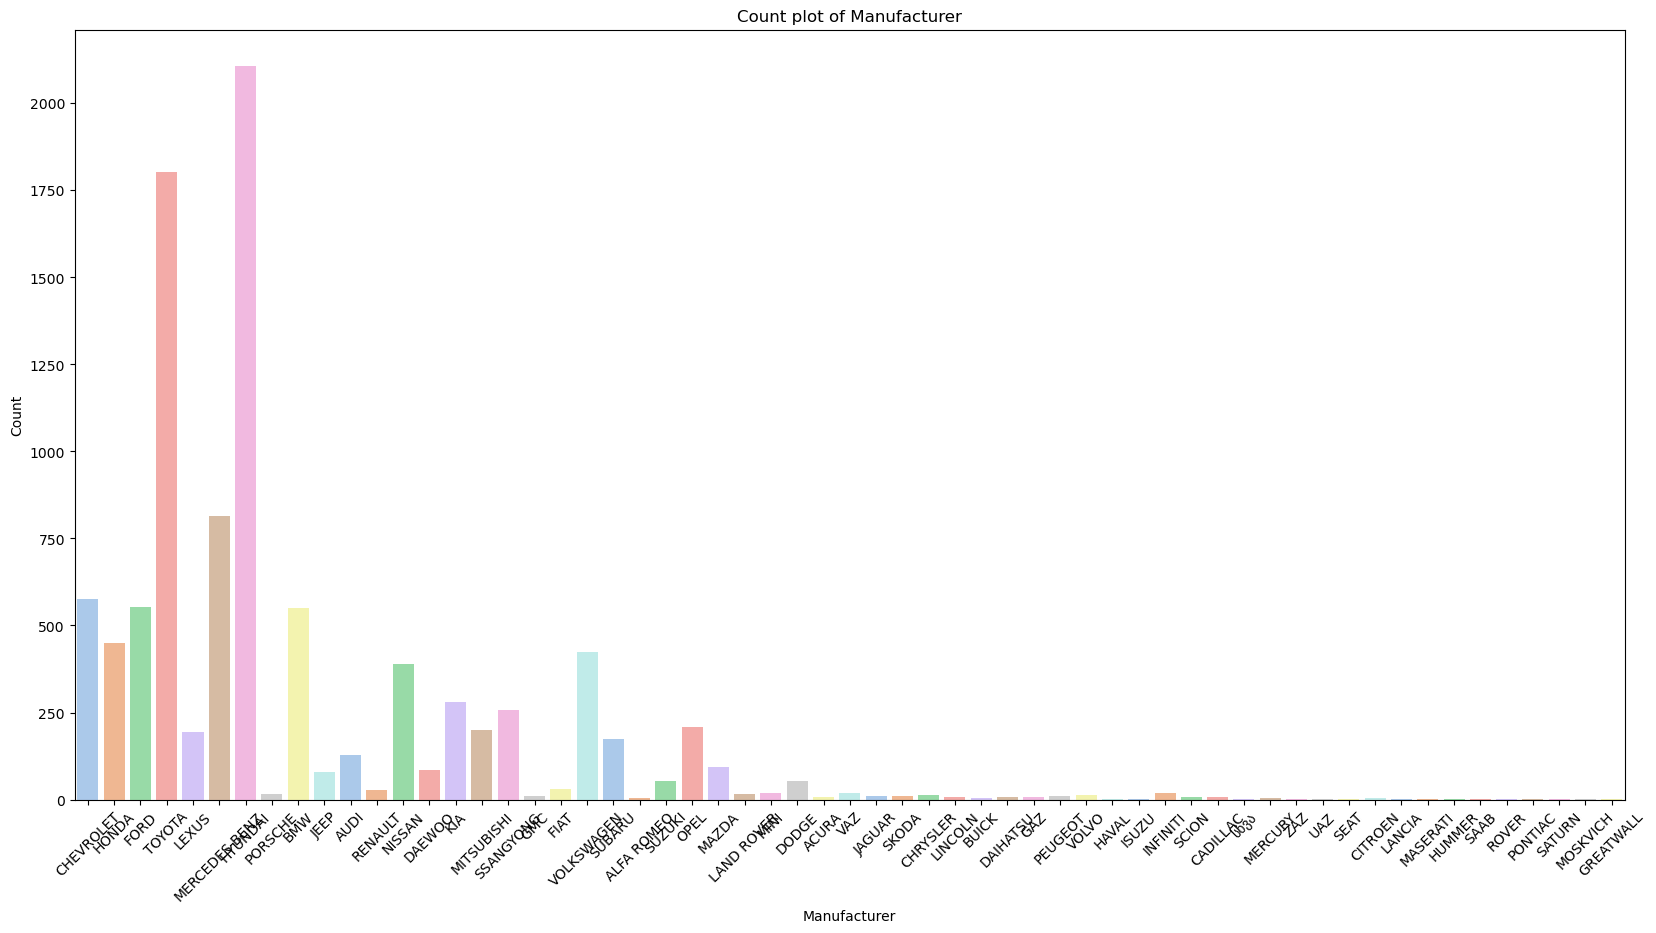

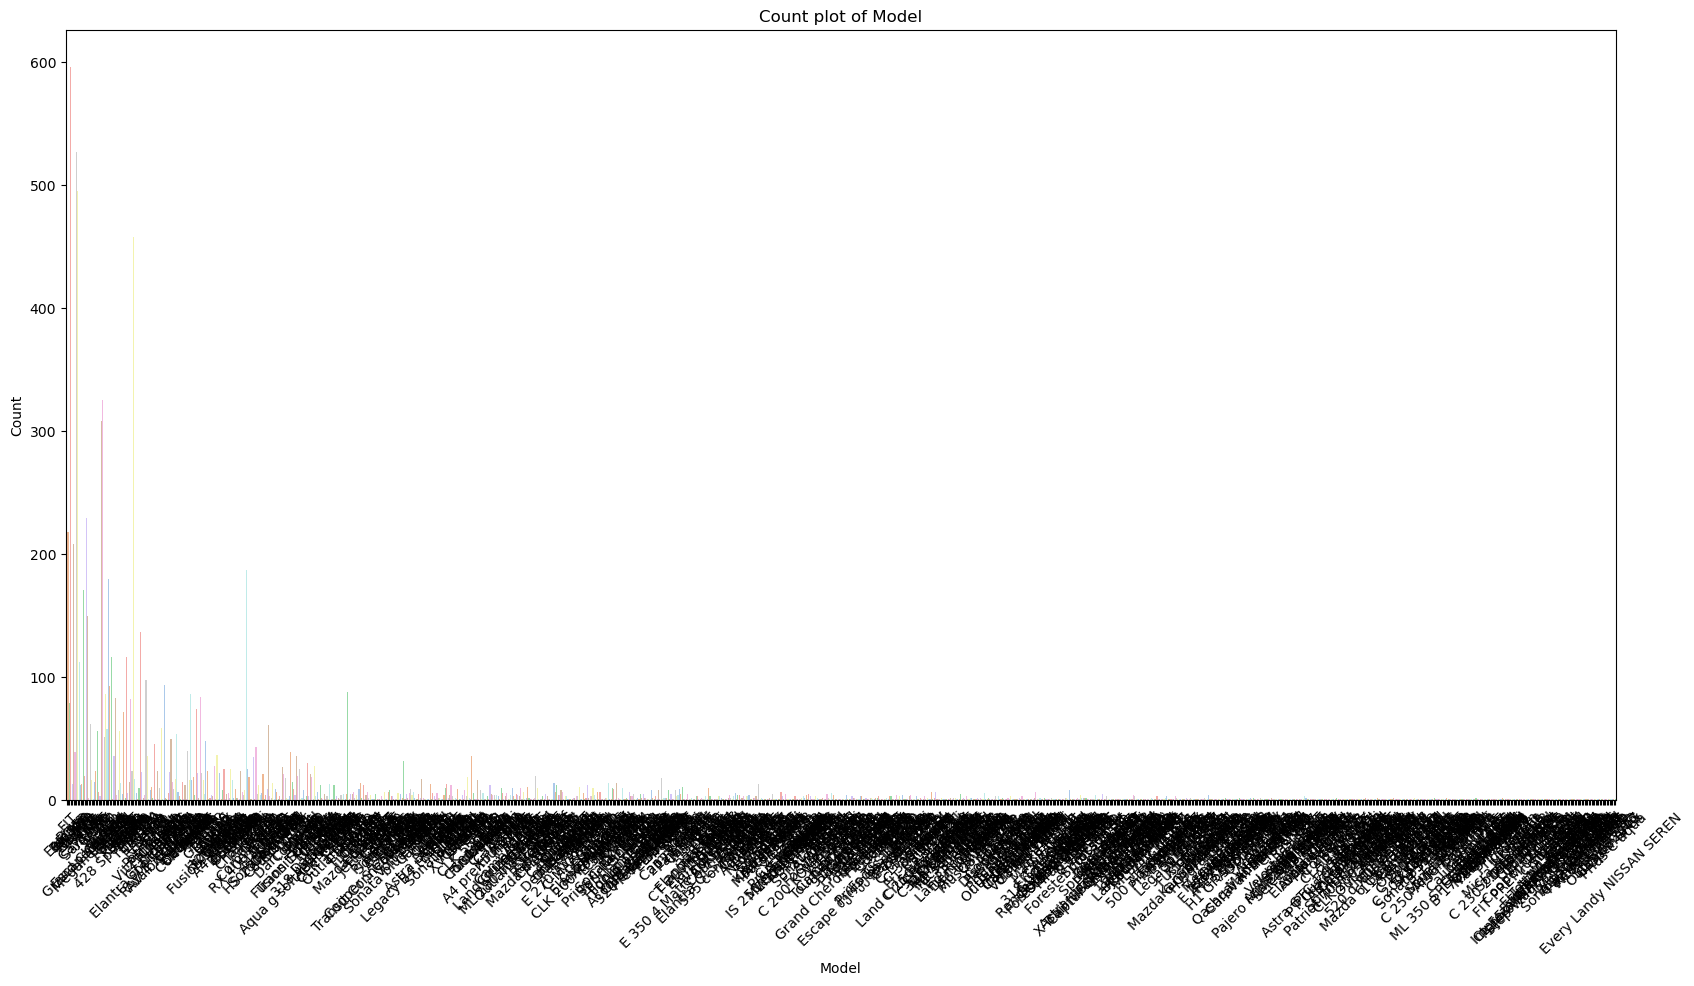

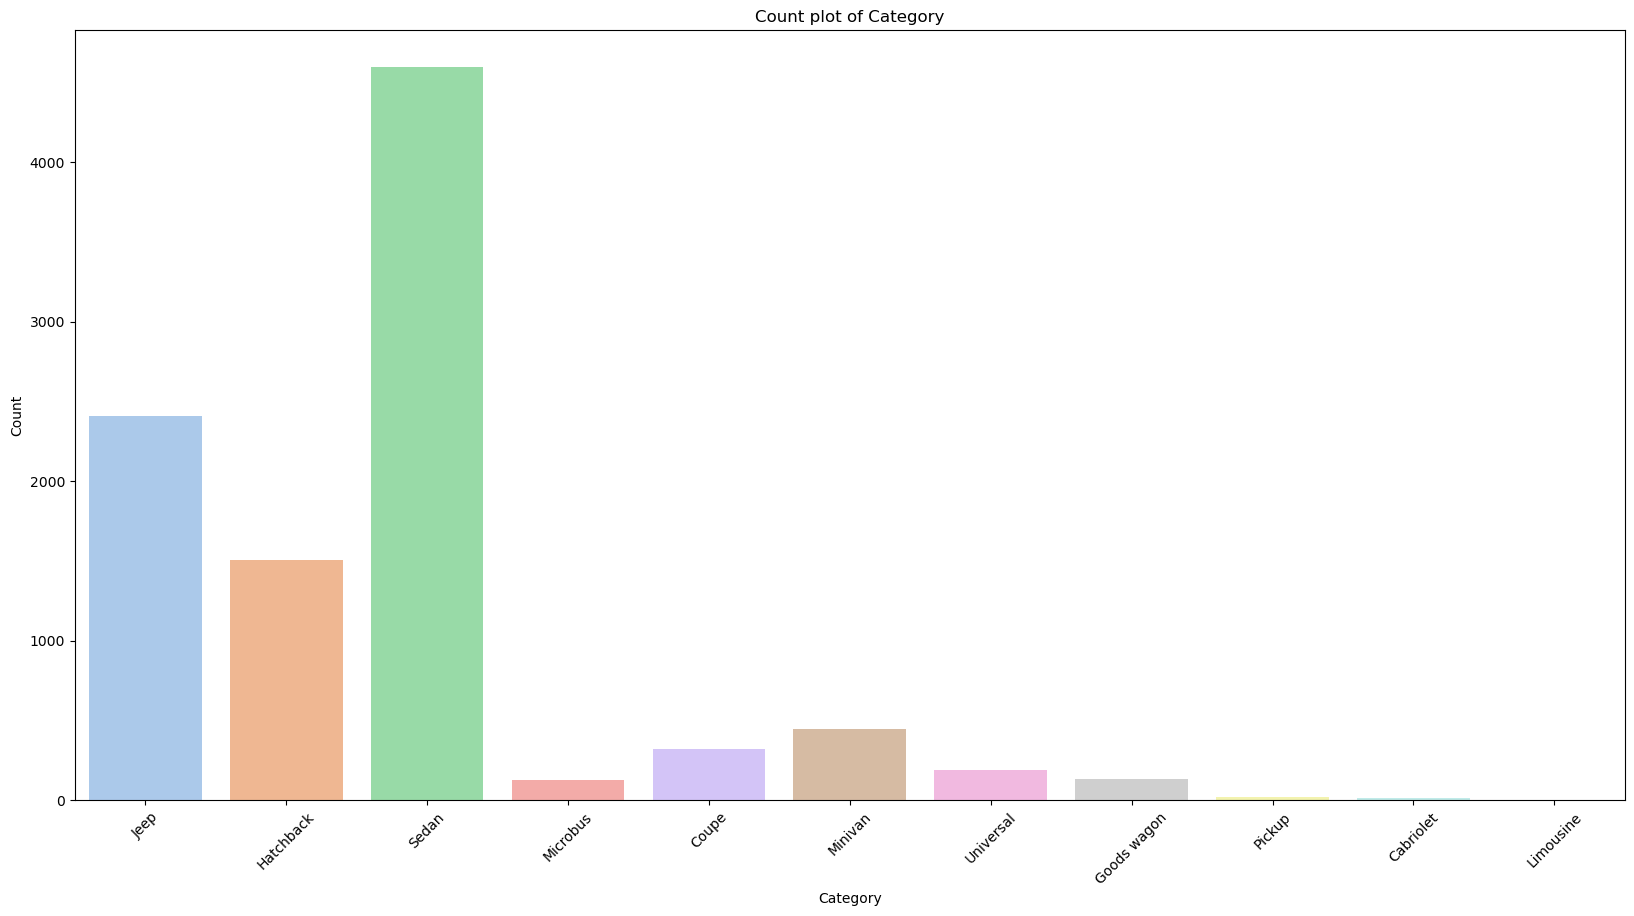

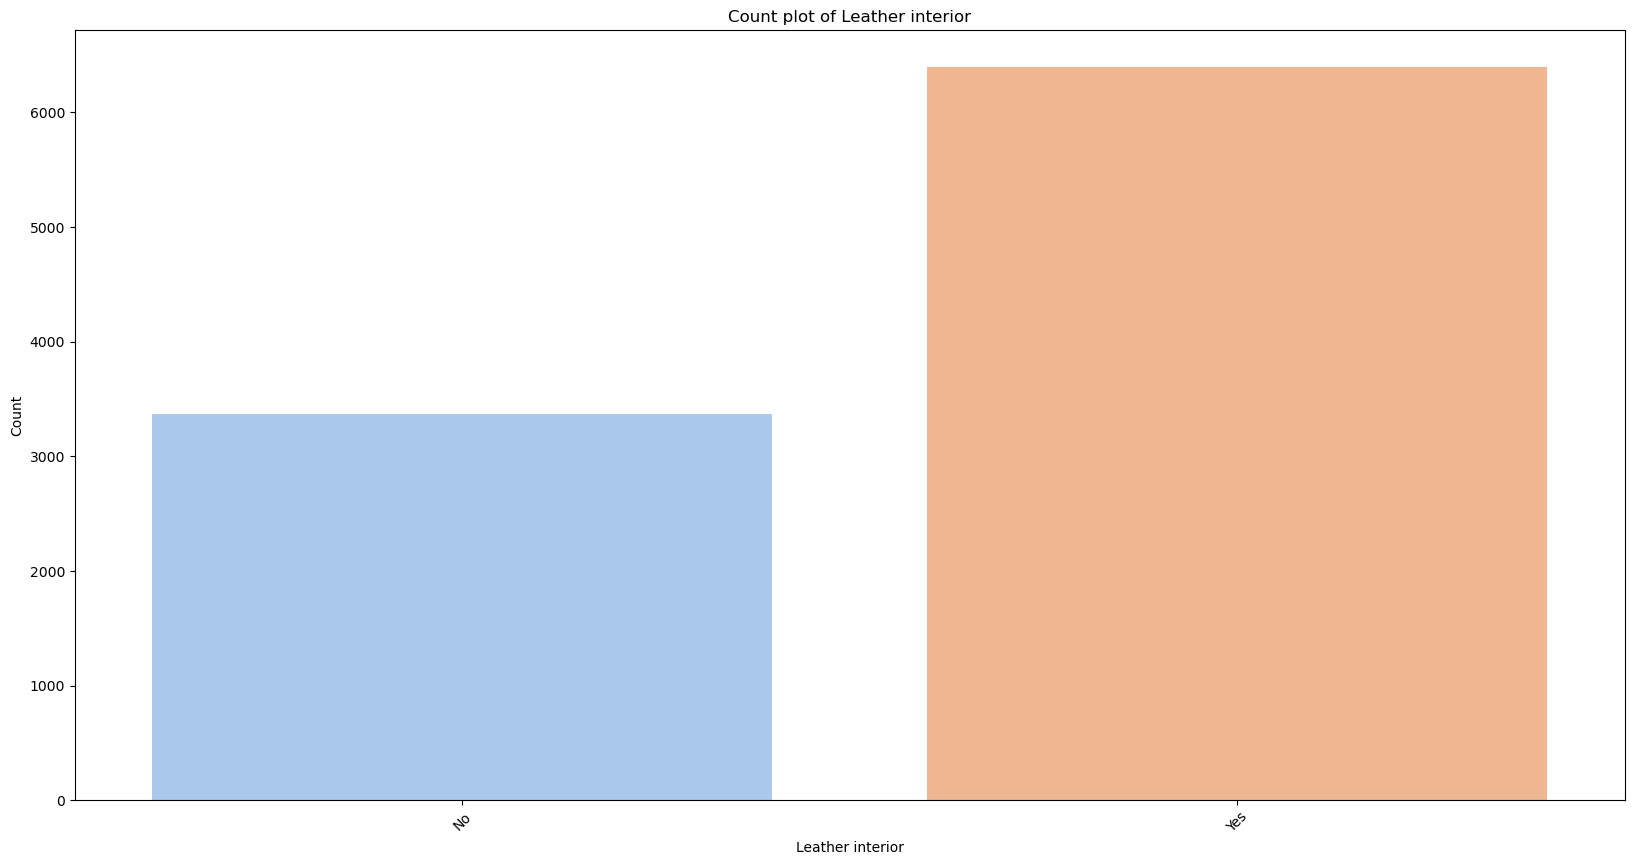

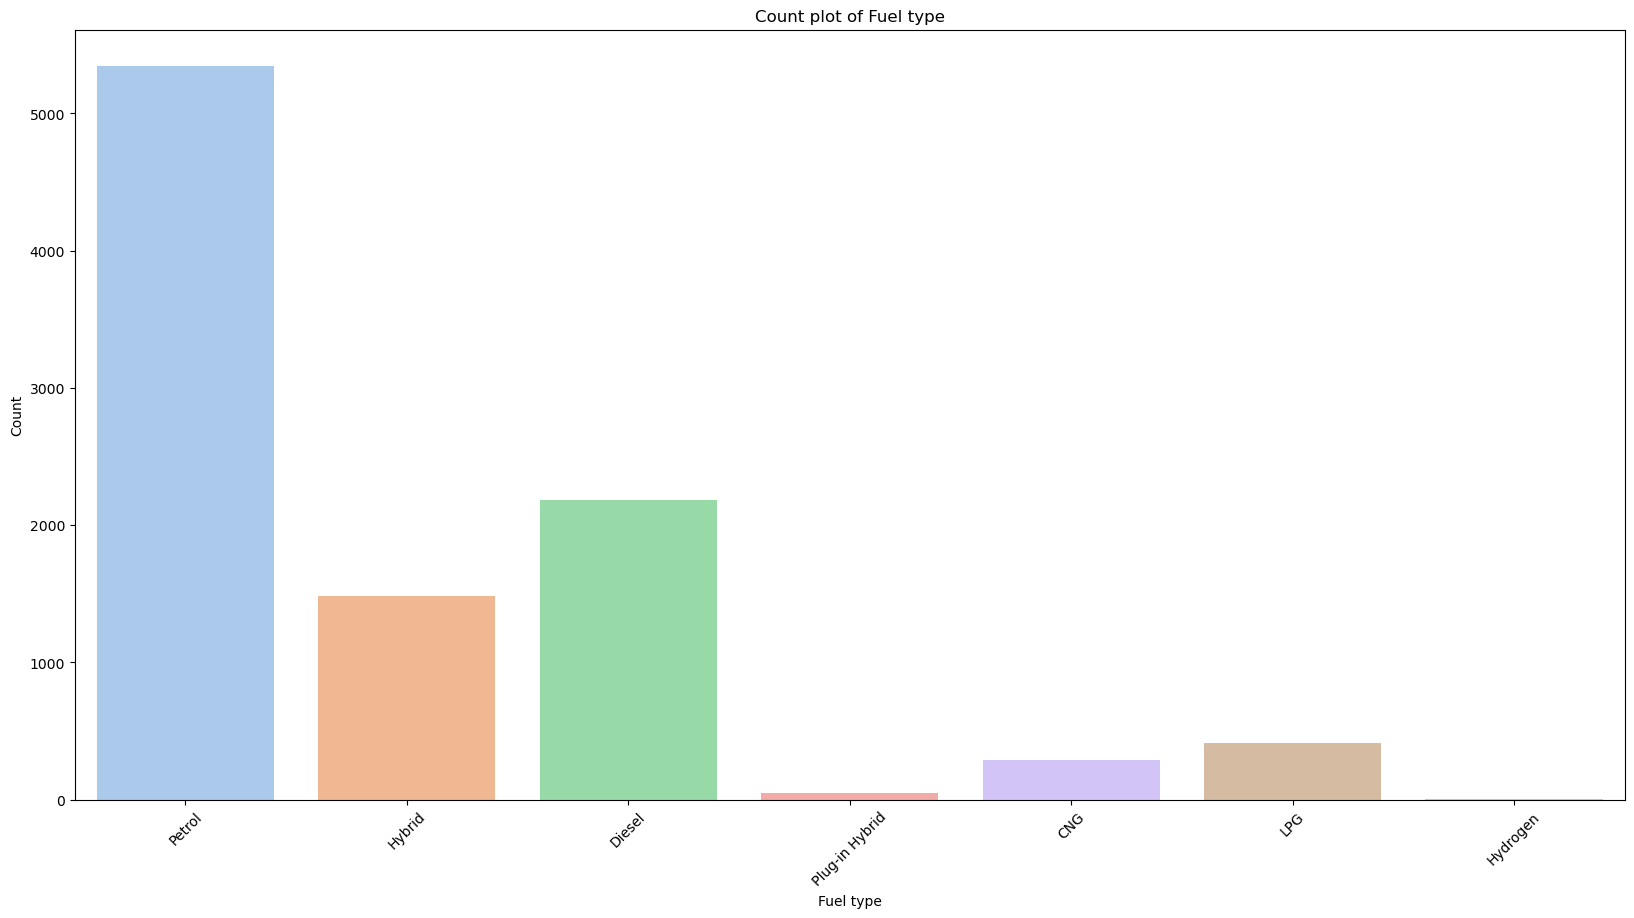

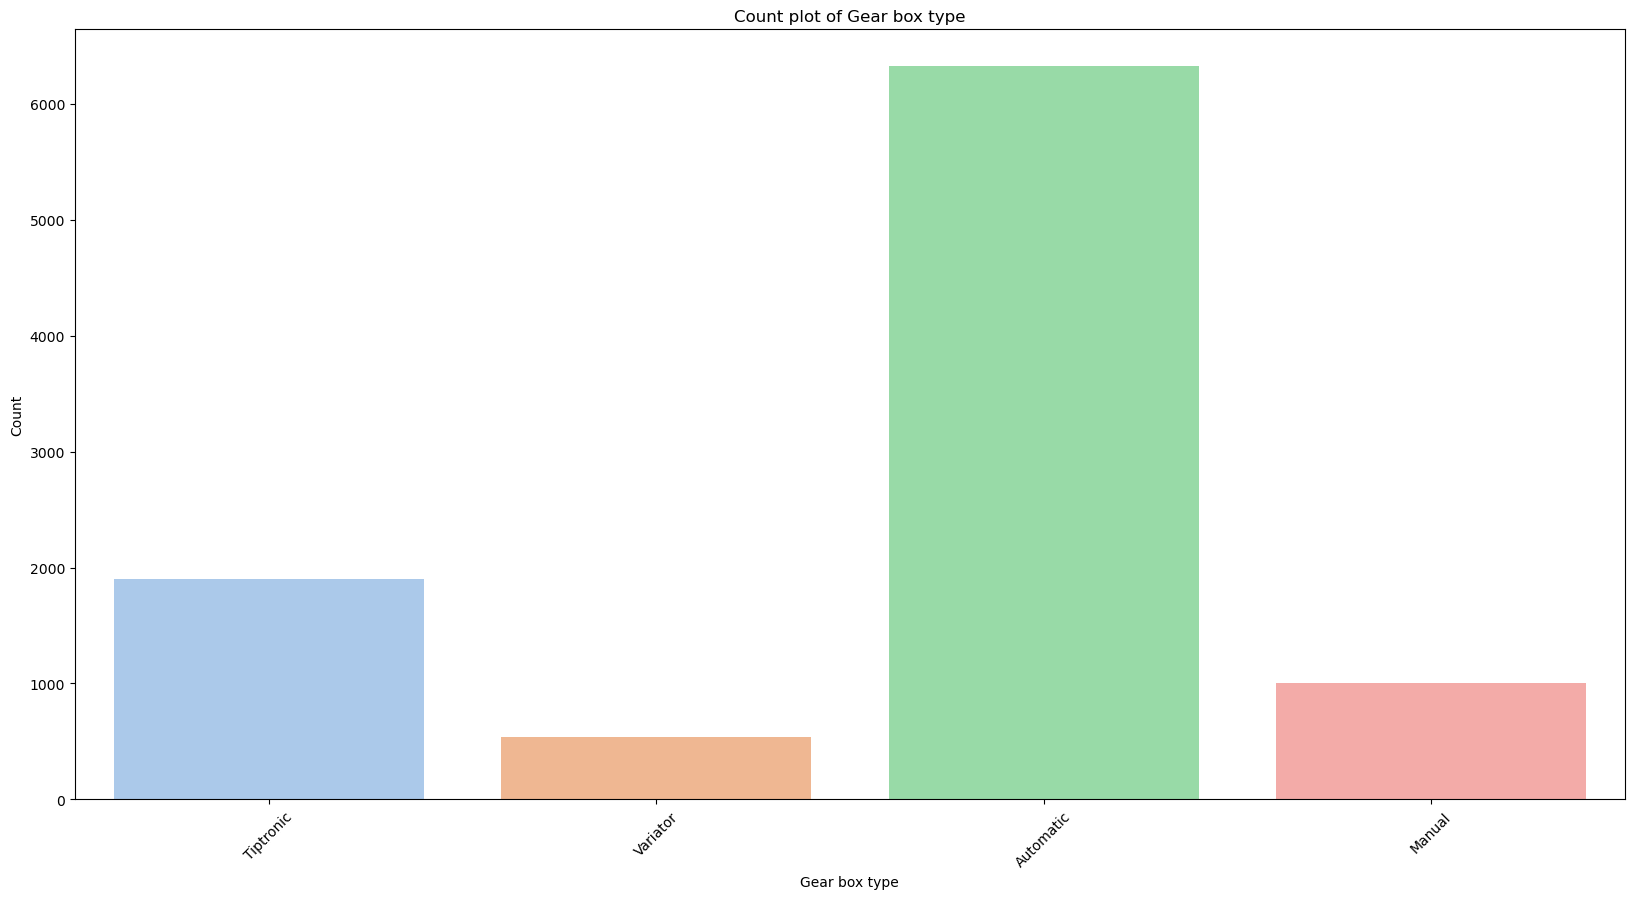

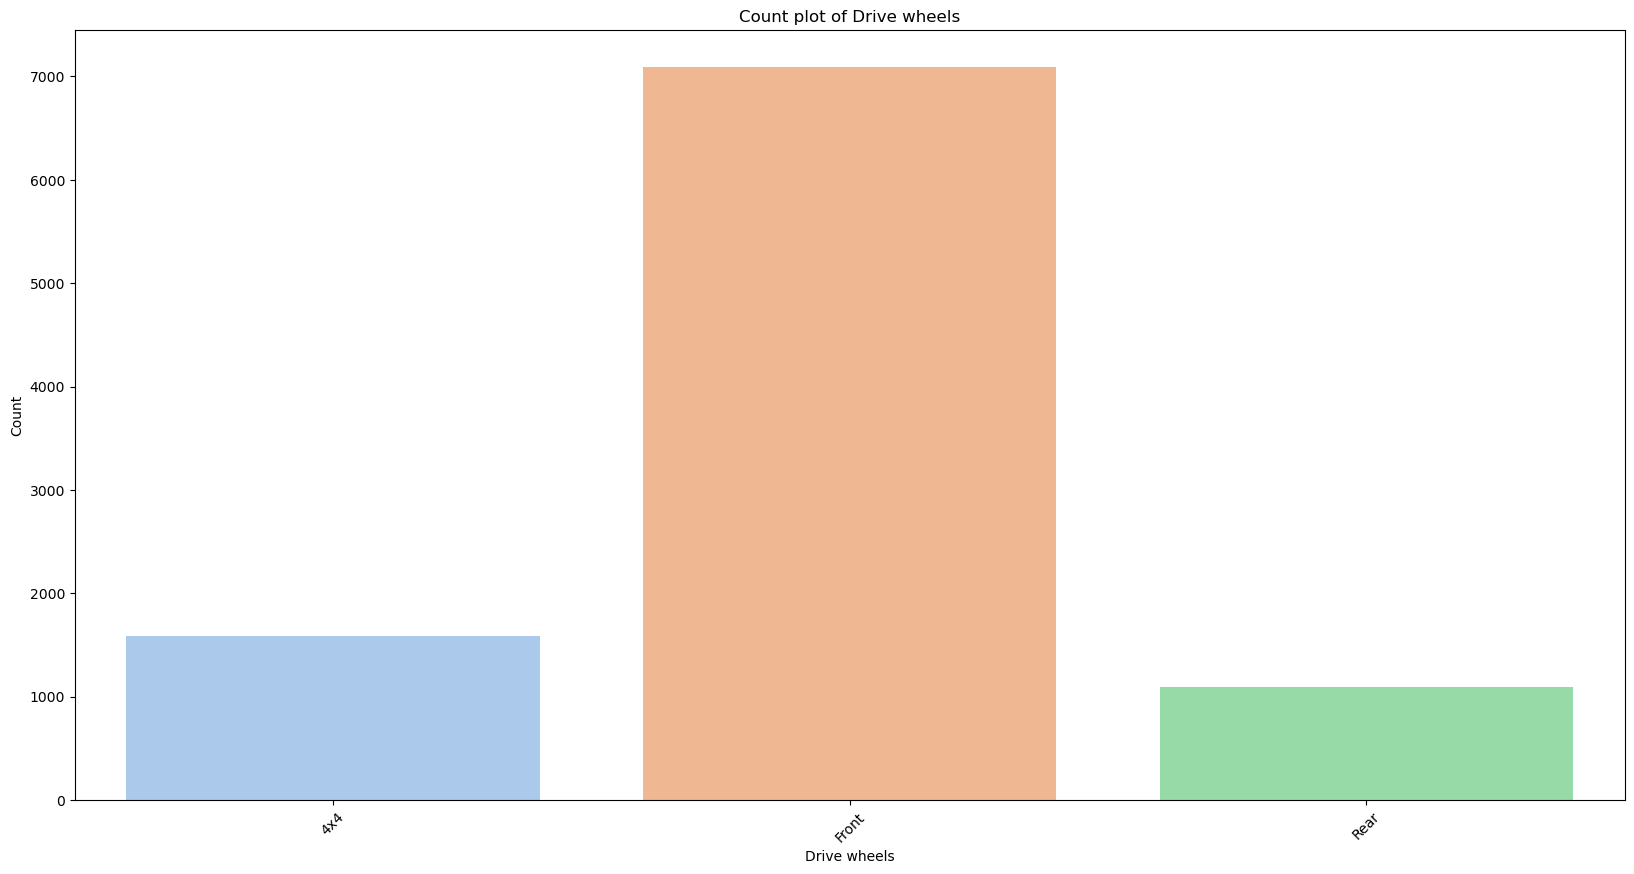

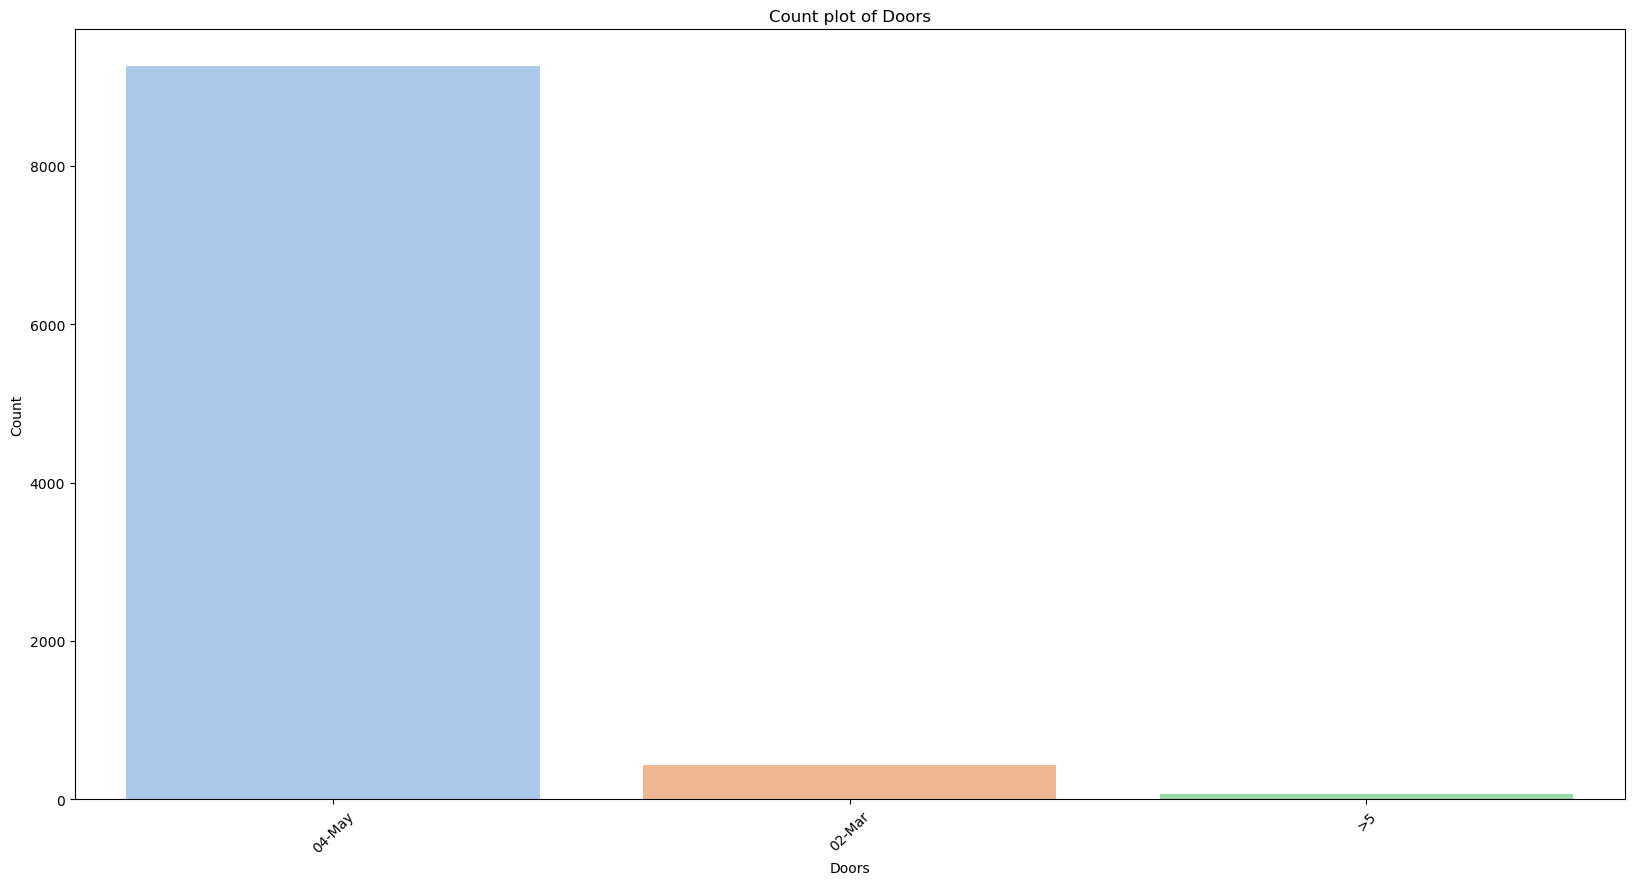

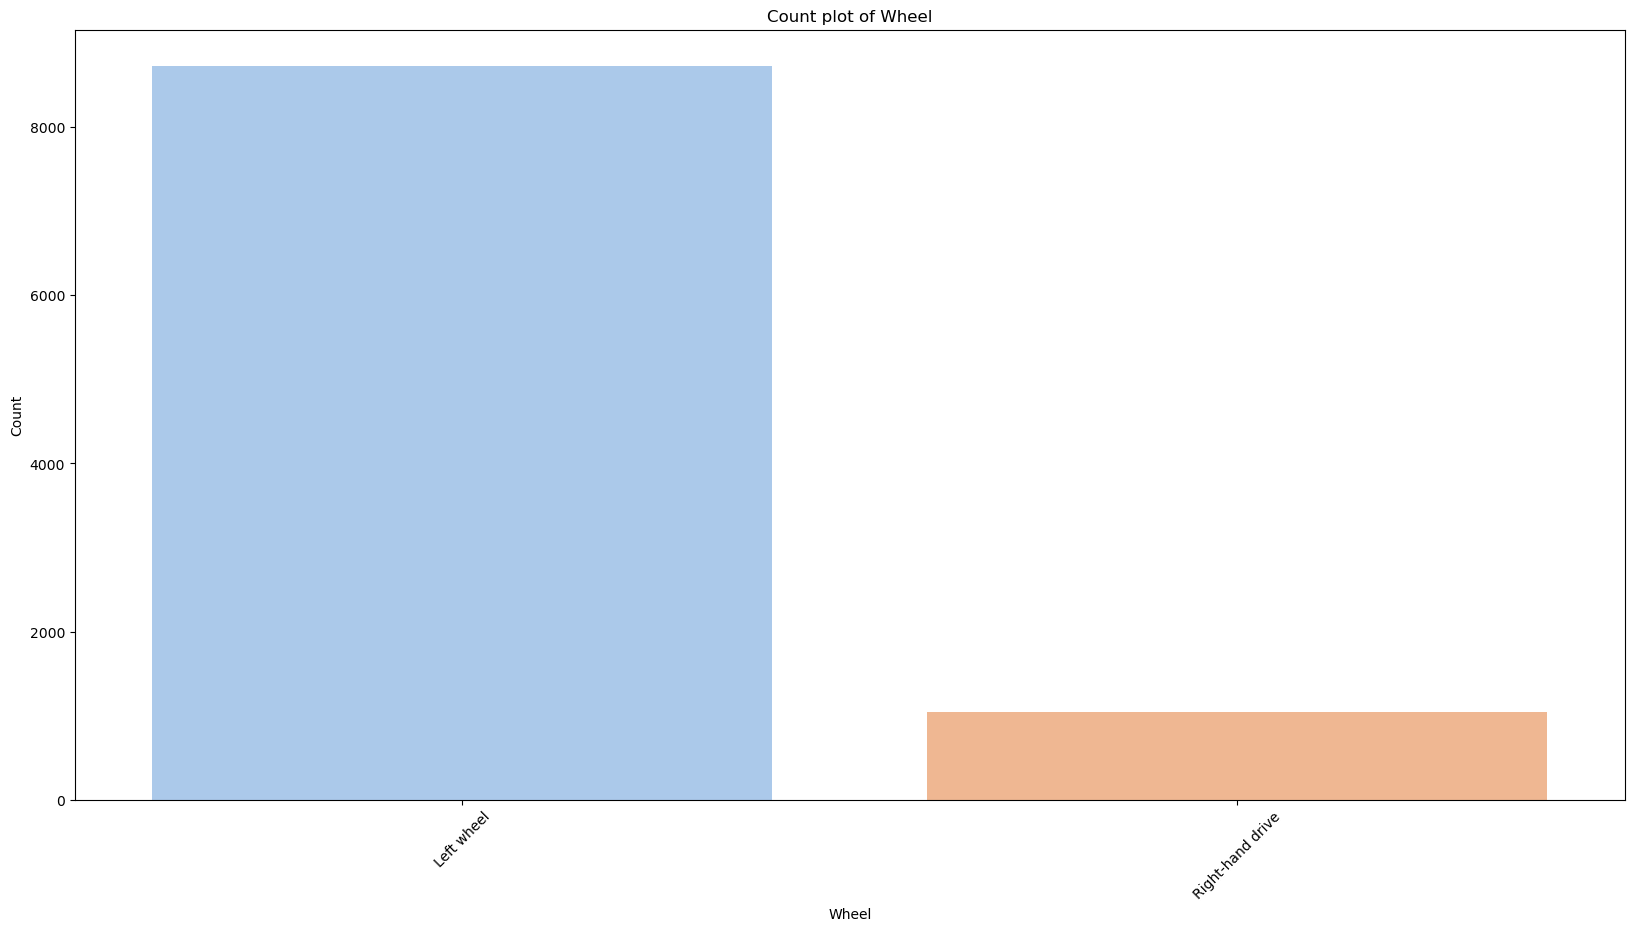

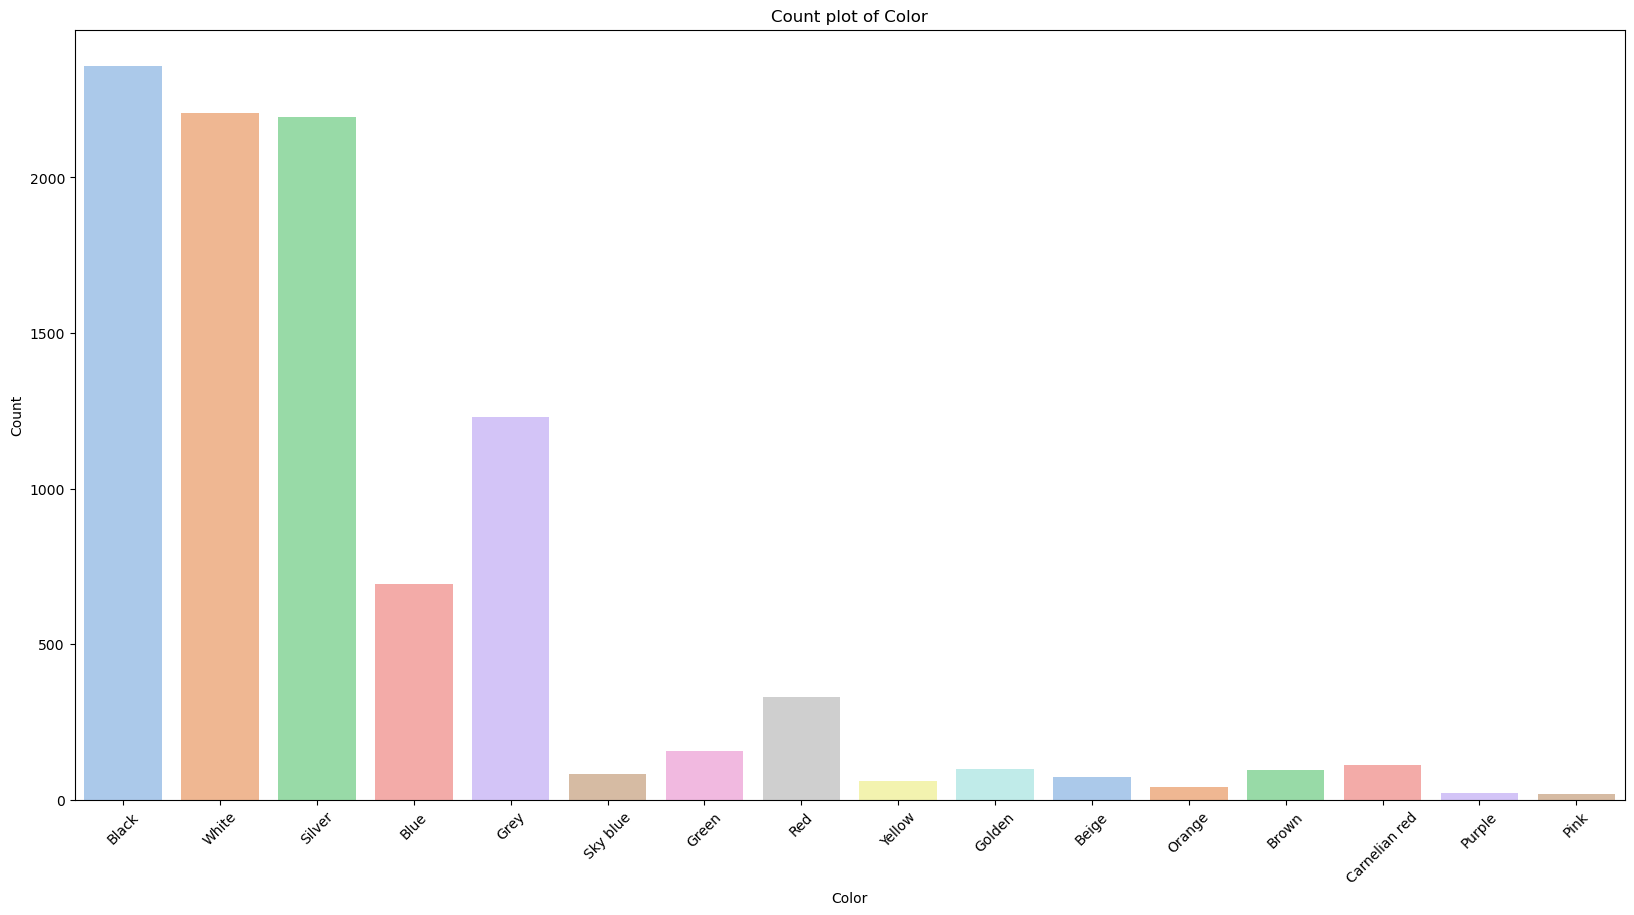

In [462]:
for col in categorical_cols:
    plt.figure(figsize=(20,10))
    sns.countplot(data=df, x=col, hue=col, palette='pastel')
    plt.title(f'Count plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45);

In [463]:
# Drop features that offer no trend or of no significant importance
# Drop the ID col and Doors cols ::: ID cols offers no value or trend, Doors col  is populated with the wrong data
cols_to_drop = ['ID', 'Doors', 'Color', 'Wheel', 'Drive wheels']
df = df.drop(cols_to_drop, axis=1)
df

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000,6.0,Tiptronic,8
2,8467,906,HONDA,FIT,2006,Hatchback,No,Petrol,2,200000,4.0,Variator,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2,168966,4.0,Automatic,0
6,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,2,258909,4.0,Automatic,12
9,26657,906,LEXUS,RX 350,2007,Jeep,Yes,Petrol,2,128500,6.0,Automatic,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,906,NISSAN,Skyline,2003,Sedan,Yes,Petrol,3,220000,6.0,Tiptronic,0
19227,29793,1053,MERCEDES-BENZ,E 350,2014,Sedan,Yes,Diesel,2,219030,6.0,Automatic,12
19231,5802,1055,MERCEDES-BENZ,E 350,2013,Sedan,Yes,Diesel,2,107800,6.0,Automatic,12
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2,161600,4.0,Tiptronic,8


In [464]:
df.head(10)

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000,6.0,Tiptronic,8
2,8467,906,HONDA,FIT,2006,Hatchback,No,Petrol,2,200000,4.0,Variator,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2,168966,4.0,Automatic,0
6,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,2,258909,4.0,Automatic,12
9,26657,906,LEXUS,RX 350,2007,Jeep,Yes,Petrol,2,128500,6.0,Automatic,12
10,941,1053,MERCEDES-BENZ,E 350,2014,Sedan,Yes,Diesel,2,184467,6.0,Automatic,12
13,1019,1055,LEXUS,RX 450,2013,Jeep,Yes,Hybrid,2,138038,6.0,Automatic,12
16,7683,810,HYUNDAI,Elantra,2016,Sedan,Yes,Petrol,2,121840,4.0,Automatic,12
17,28382,810,HYUNDAI,Elantra,2016,Sedan,Yes,Petrol,2,54317,4.0,Automatic,4
21,20698,586,TOYOTA,Prius,2012,Sedan,Yes,Plug-in Hybrid,2,187000,4.0,Automatic,12


In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9770 entries, 1 to 19234
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             9770 non-null   int64  
 1   Levy              9770 non-null   int64  
 2   Manufacturer      9770 non-null   object 
 3   Model             9770 non-null   object 
 4   Prod. year        9770 non-null   int64  
 5   Category          9770 non-null   object 
 6   Leather interior  9770 non-null   object 
 7   Fuel type         9770 non-null   object 
 8   Engine volume     9770 non-null   int64  
 9   Mileage           9770 non-null   int64  
 10  Cylinders         9770 non-null   float64
 11  Gear box type     9770 non-null   object 
 12  Airbags           9770 non-null   int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 1.0+ MB


In [466]:
cleaned_df = df.copy()

In [467]:
"""STANDARDIZATION"""
scaler = StandardScaler()

scaled_data = scaler.fit_transform(cleaned_df[['Mileage']])

cleaned_df['Mileage'] = scaled_data

In [468]:
cleaned_df

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,0.953942,6.0,Tiptronic,8
2,8467,906,HONDA,FIT,2006,Hatchback,No,Petrol,2,1.090471,4.0,Variator,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2,0.560843,4.0,Automatic,0
6,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,2,2.095815,4.0,Automatic,12
9,26657,906,LEXUS,RX 350,2007,Jeep,Yes,Petrol,2,-0.129752,6.0,Automatic,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,906,NISSAN,Skyline,2003,Sedan,Yes,Petrol,3,1.431792,6.0,Tiptronic,0
19227,29793,1053,MERCEDES-BENZ,E 350,2014,Sedan,Yes,Diesel,2,1.415238,6.0,Automatic,12
19231,5802,1055,MERCEDES-BENZ,E 350,2013,Sedan,Yes,Diesel,2,-0.483020,6.0,Automatic,12
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2,0.435134,4.0,Tiptronic,8


In [474]:
cleaned_df.groupby(['Manufacturer', "Model"])['Model'].count().sort_values(ascending=False)

Manufacturer  Model        
TOYOTA        Prius            596
HYUNDAI       Elantra          527
TOYOTA        Camry            495
HYUNDAI       Sonata           458
              H1               325
                              ... 
VOLVO         C30 2010           1
              C70                1
              S40                1
              V50                1
              XC90 2.5turbo      1
Name: Model, Length: 1121, dtype: int64

In [ ]:
# Dsplay the Manufacturer, Model against the Category
cat_df = cleaned_df.copy()
cat_df['group'] = cat_df.fuel
pivot_table = pd.pivot_table(cat_df, values='Prod. year', index=['group'])